# Distribution of hyperparameters

In this notebook we generate a KDE plot and histogram for each of the numerical hyperparameters.

In [1]:
import os
from scipy.io import arff
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n = 10 # retrieve only n settings per dataset per classifier with highest accuracy  
m = 40 # minimum number of observations per dataset to be included

# load data
data = arff.loadarff('data/meta_svm.arff')
svm = pd.DataFrame(data[0])
data = arff.loadarff('data/meta_random_forest.arff')
rf = pd.DataFrame(data[0])
data = arff.loadarff('data/meta_adaboost.arff')
ada = pd.DataFrame(data[0])

# load alg names and dataframes
g = svm.groupby('kernel')
algs = ['svm_' + s.decode('UTF-8') for s in list(g.groups.keys())] + ['rf', 'ada']
dfs_all = [g.get_group(x) for x in g.groups] + [rf, ada]

# retrieve top n for all dataframes
dfs = []
for df, alg in zip(dfs_all, algs):
    groups = []
    for g in df.groupby(['task_id']):
        group = pd.DataFrame(g[1])
        group['task_id'] = g[0]
        if len(group) > m:
            groups.append(group.sort_values(by = 'y', ascending  = False)[0:n])
        else: 
            print('Dataset %s not included for classifier %s because no. obervations is %s.' %(int(g[0]), alg, int(len(group))))
    dfs.append(pd.concat(groups))

for i, j in zip(dfs,algs):
    print('Classifier: %s, Nr. of observations: %s' %(j, len(i)))

Dataset 18 not included for classifier svm_poly because no. obervations is 27.
Dataset 3913 not included for classifier svm_poly because no. obervations is 30.
Dataset 3917 not included for classifier svm_poly because no. obervations is 36.
Dataset 14965 not included for classifier svm_poly because no. obervations is 9.
Dataset 14968 not included for classifier svm_poly because no. obervations is 32.
Dataset 3948 not included for classifier svm_rbf because no. obervations is 28.
Classifier: svm_poly, Nr. of observations: 950
Classifier: svm_rbf, Nr. of observations: 980
Classifier: svm_sigmoid, Nr. of observations: 990
Classifier: rf, Nr. of observations: 1000
Classifier: ada, Nr. of observations: 1000


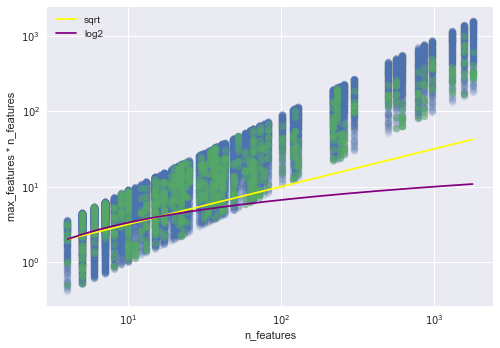

In [26]:
import numpy as np 

max_features = dfs[3]['max_features']*dfs[3]['NumberOfFeatures']
n_features = dfs[3]['NumberOfFeatures']
x = range(int(min(n_features)), int(max(n_features)))

plt.scatter(rf['NumberOfFeatures'], rf['max_features']*rf['NumberOfFeatures'], alpha = 0.05)
fit = np.polyfit(np.log(n_features), np.log(max_features), deg=1)
plt.scatter(n_features, max_features, alpha = 0.5)
#plt.plot(x, np.exp(fit[0] * np.log(x) + fit[1]), color='red', label='e^(%.2f * ln(n_features) + %.2f)'%(fit[0], fit[1]))
plt.plot(x,np.sqrt(x), label='sqrt', c = 'yellow')
plt.plot(x,np.log2(x), label ='log2', c = 'purple')

plt.xlabel('n_features')
plt.ylabel('max_features * n_features')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.show()

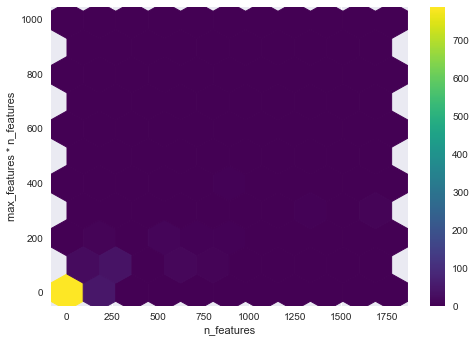

In [57]:
#plt.xscale('log')
#plt.yscale('log')
ax = plt.hexbin(n_features, max_features, cmap = 'viridis', gridsize = 10)
plt.xlabel('n_features')
plt.ylabel('max_features * n_features')

plt.colorbar(ax)
plt.show()

In [5]:
# hyperparameters to be evaluated
alg_params = {'svm_poly': ['gamma','C','tol','coef0'],
              'svm_rbf': ['gamma','C','tol'],
              'svm_sigmoid': ['gamma','C','tol','coef0'],
              'rf': ['max_features','min_samples_leaf','min_samples_split'],
              'ada': ['learning_rate','max_depth','n_estimators']}

# parameters defined on a log scale
logs = ['gamma', 'C', 'tol', 'learning_rate']
integer = ['min_samples_leaf', 'min_samples_split', 'max_depth', 'n_estimators']

## Histograms

The number of bins is
    - log scale: 20
    - integer: max - min + 1
    - otherwise: 'auto'

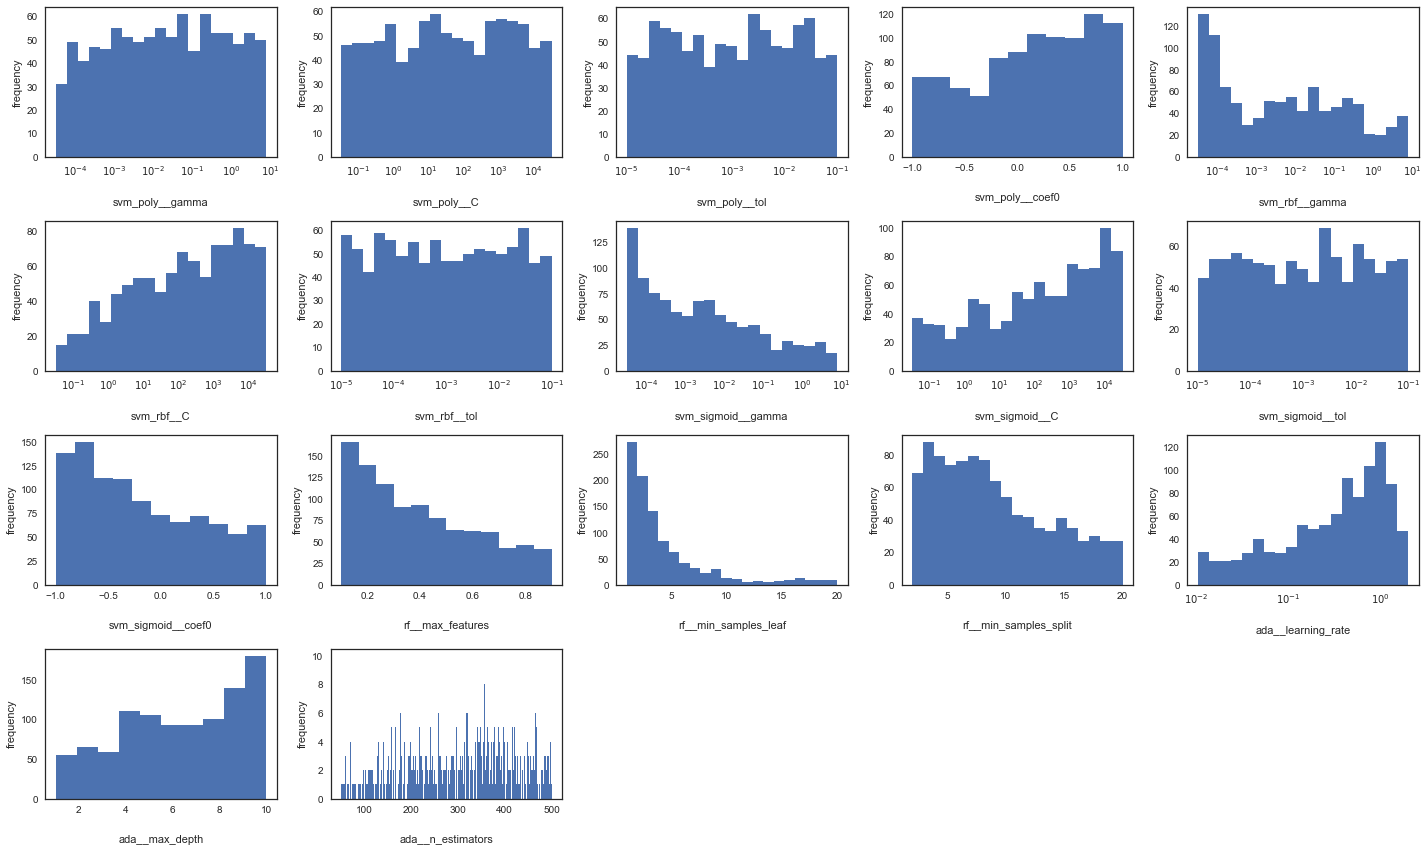

In [12]:
grid = True # put images on grid or not
cols = 5 # set nr columns in figure grid
ymax = None # set upper limit of plot; None for auto

if grid:
    nr_plots = sum([len(value) for key, value in alg_params.items()])
    rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
    plt.figure(figsize = (4*cols,3*rows))
    index = 0
for alg, df in zip(algs, dfs):
    for param in alg_params[alg]:
        if grid:
            index += 1
            plt.subplot(rows, cols, index)
        bins = 'auto'
        log = param in logs
        intg = param in integer
        if log:
            bins = np.logspace(np.log10(min(df[param])), np.log10(max(df[param])), 20)
            plt.xscale('log')
        if intg:
            bins = int(max(df[param]) - min(df[param]) + 1)
        plt.hist(df[param], bins = bins)
        plt.xlabel('%s__%s' % (alg, param), labelpad=20)
        plt.ylim(0,ymax)
        plt.ylabel('frequency')
        plt.tight_layout()
        if not grid:
            #plt.savefig('figures/histograms/hist__%s__%s.eps' % (alg, param), format = 'eps')
            plt.show()
if grid:
    plt.show()

## KDE plots

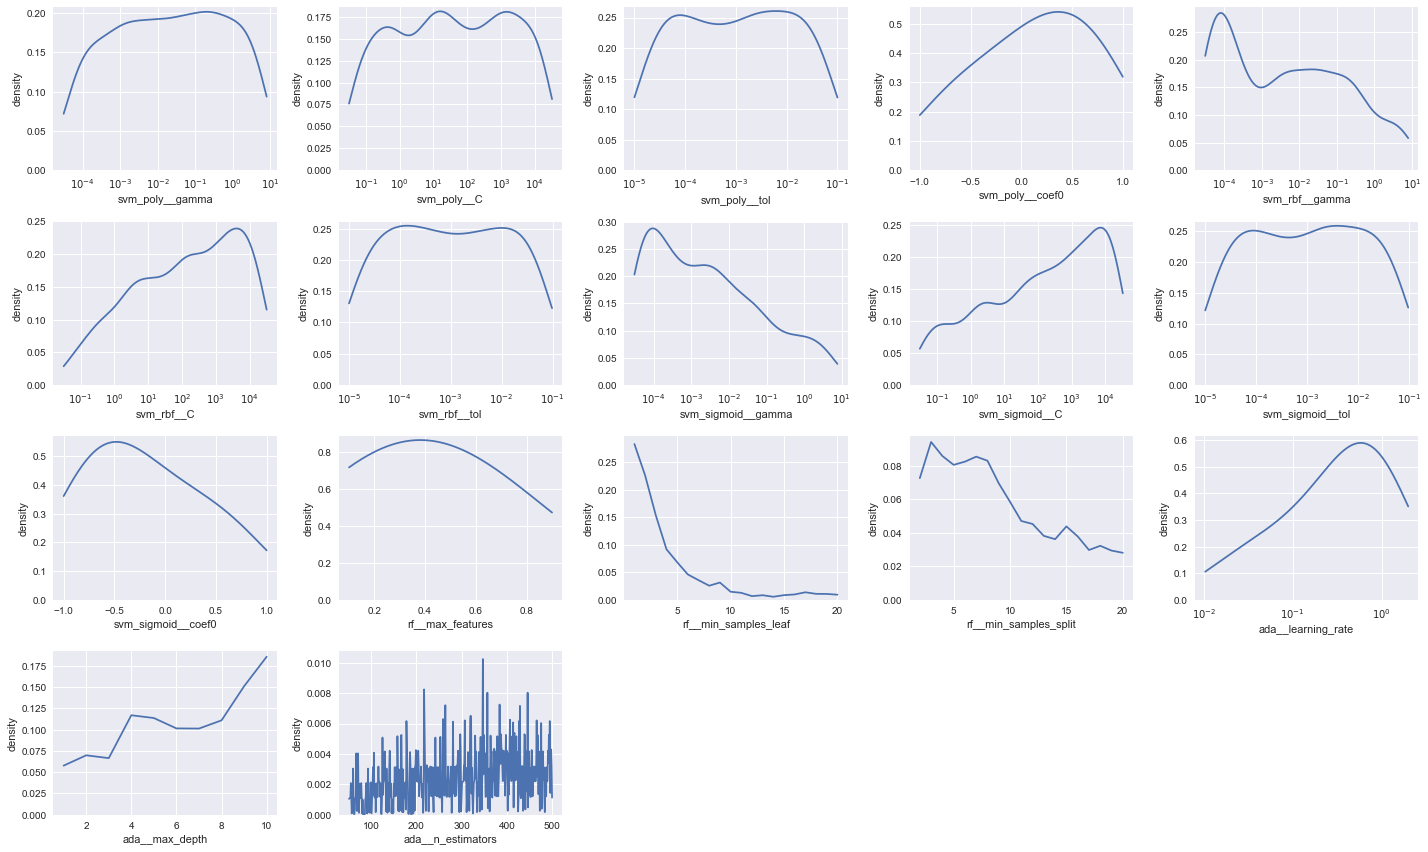

In [7]:
bandwidth = 0.4
step_size = 500 #nr of points that are evaluated for the kde
grid = True # put images on grid or not
cols = 5 # set nr columns in the grid
ymax = None #limit of y axis; None for auto

if grid:
    nr_plots = sum([len(value) for key, value in alg_params.items()])
    rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
    plt.figure(figsize = (4*cols,3*rows))
    index = 0
    
for alg, df in zip(algs, dfs):
    for param in alg_params[alg]:
        log = param in logs
        intg = param in integer
        
        if log:
            data = np.log10(df[param].as_matrix().transpose())
        else: 
            data = df[param].as_matrix().transpose()
            
        # fit kernel
        kde = stats.gaussian_kde(data, bw_method = bandwidth/data.std(ddof=1))
        
        # evaluate kernel
        x_min = min(data)
        x_max = max(data)
        if intg:
            steps = int(x_max - x_min + 1)
        else:
            steps = step_size
        x = np.linspace(x_min, x_max, steps)
        y = kde.evaluate(x)
        
        # plot figure
        if grid:
            index += 1
            plt.subplot(rows, cols, index)

        if log:
            x = 10**x
        plt.plot(x,y,'-')
        plt.ylim(0,ymax)
        plt.ylabel('density')
        plt.xlabel('%s__%s' % (alg, param))
        if log:
            plt.xticks(x)
            plt.xscale('log')
        plt.tight_layout()
        
        if not grid:
            #plt.savefig('figures/kdes/kde__%s__%s.eps' % (alg, param), format = 'eps')
            plt.show()
if grid:
    plt.show()

# Histogram + KDE plots

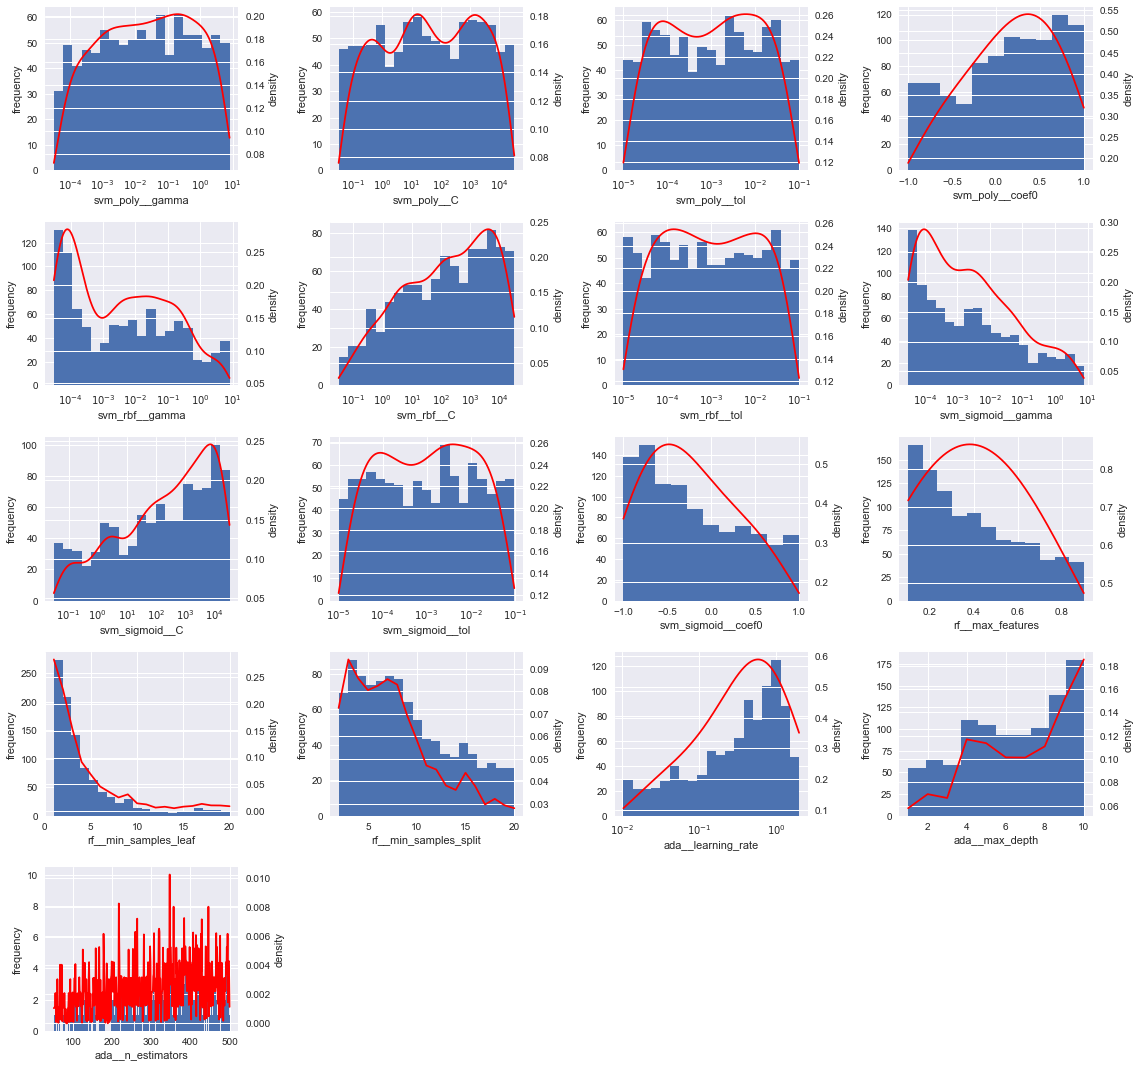

In [8]:
cols = 4 #nr columns in the grid

# Parameters for KDE
#bandwidth = None # bandwidth of kde
bandwidth = 0.4
step_size = 500 #nr of points that are evaluated for the kde

nr_plots = sum([len(value) for key, value in alg_params.items()])
rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
fig = plt.figure(figsize = (4*cols,3*rows))
index = 1
for alg, df in zip(algs, dfs):
    for param in alg_params[alg]:
        log = param in logs
        intg = param in integer
        
        if log:
            data = np.log10(df[param].as_matrix().transpose())
        else: 
            data = df[param].as_matrix().transpose()
        
        # fit kernel
        kde = stats.gaussian_kde(data, bw_method = bandwidth/data.std(ddof=1))
        
        # evaluate kernel
        x_min = min(data)
        x_max = max(data)
        if intg:
            steps = int(x_max - x_min + 1)
        else:
            steps = step_size
        x = np.linspace(x_min, x_max, steps)
        y = kde.evaluate(x)
        if log:
            x = 10**x
        
        # create axes
        ax1 = fig.add_subplot(rows, cols, index)
        ax2 = ax1.twinx()
        
        # plot histogram
        bins = 'auto'
        if log:
            bins = np.logspace(np.log10(min(df[param])), np.log10(max(df[param])), 20)
            ax1.set_xscale('log')
        if intg:
            bins = int(max(df[param]) - min(df[param]) + 1)
            
        ax1.hist(df[param], bins = bins)
        ax1.set_xlabel('%s__%s' % (alg, param))
        ax1.set_ylabel('frequency')
      #  ax1.set_ylim(0,1000)
        
        # plot kde plot
        ax2.plot(x,y,'r-')
      #  ax2.set_ylim(0,1)
        ax2.set_ylabel('density')
        
        plt.grid(True)
        index += 1
        plt.tight_layout()
plt.show()

# 2D KDE plots

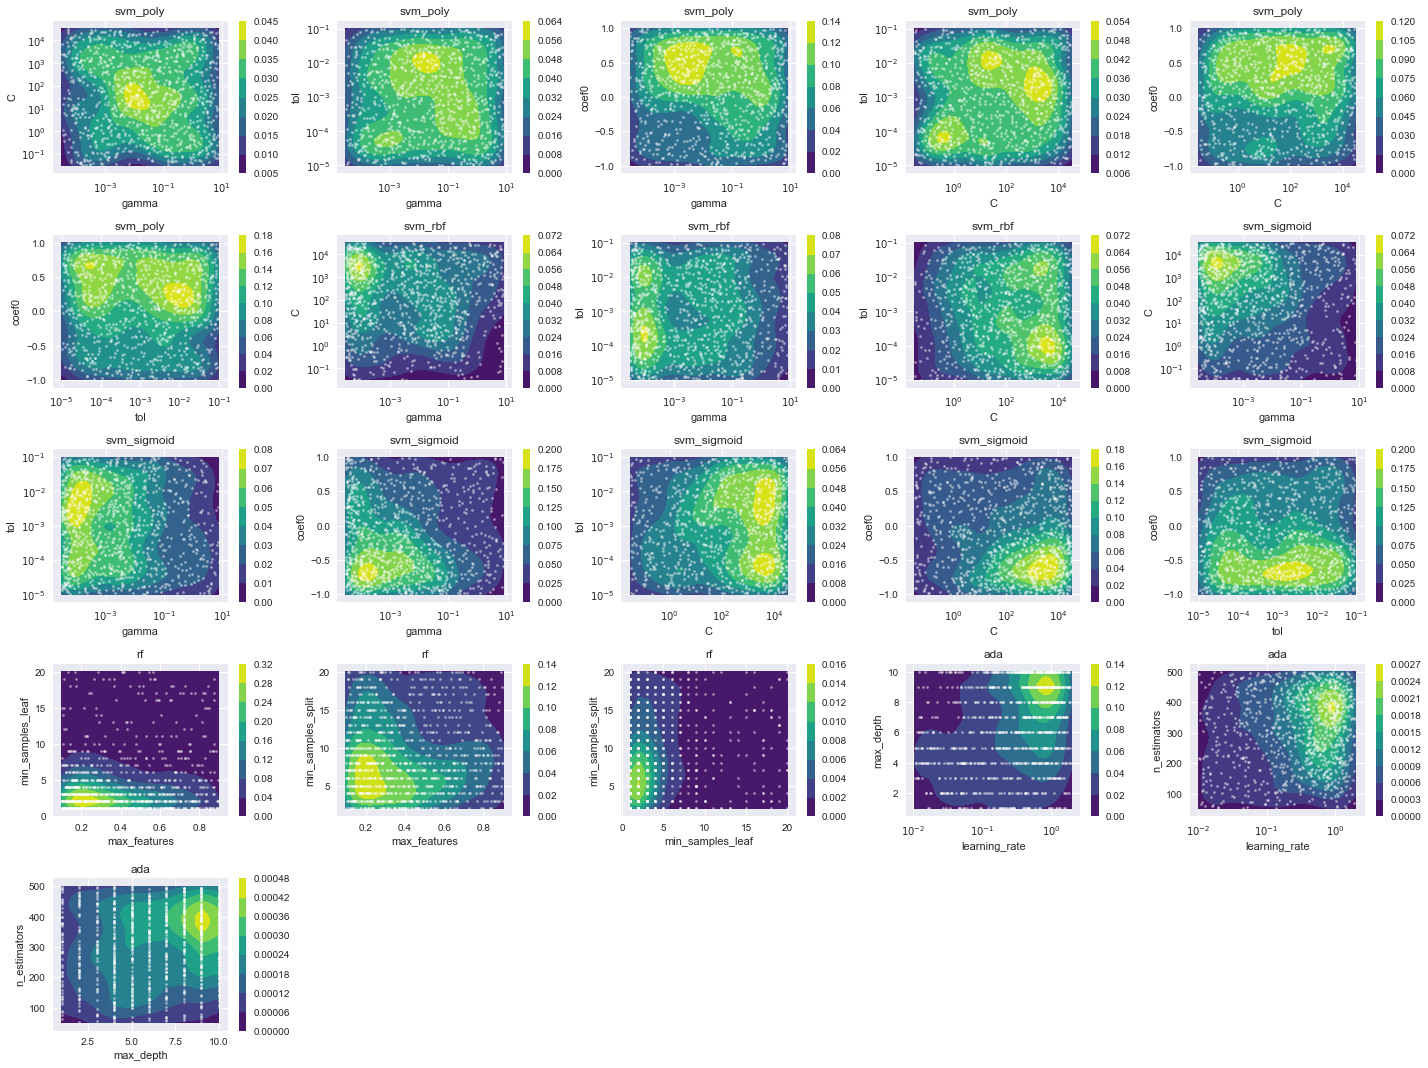

In [9]:
bandwidth = None
step_size = 100 #nr of points that are evaluated for the kde
grid = True # put images on grid or not
cols = 5 # set nr columns in the grid

nr_plots = 1
for alg, df in zip(algs, dfs):
    for i in range(0, len(alg_params[alg])):
        for j in range(i + 1, len(alg_params[alg])):
            nr_plots += 1
rows = math.ceil(nr_plots/cols)
fig = plt.figure(figsize = (4*cols,3*rows))
index = 0
    
for alg, df in zip(algs, dfs):
    for i in range(0, len(alg_params[alg])):
        for j in range(i + 1, len(alg_params[alg])):
            index += 1
            param1 = alg_params[alg][i]
            param2 = alg_params[alg][j]
            log1 = param1 in logs
            intg1 = param1 in integer
            log2 = param2 in logs
            intg2 = param2 in integer
            
            if log1:
                x = np.log10(df[param1])
            else:
                x = df[param1]
            if log2:
                y = np.log10(df[param2])
            else:
                y = df[param2]
            xmin, xmax = x.min(), x.max()
            ymin, ymax = y.min(), y.max()
            if intg1:
                steps_x = complex(str(int(xmax - xmin + 1)) + 'j')
            else:
                steps_x = complex(str(step_size) + 'j')
            if intg2:
                steps_y = complex(str(int(ymax - ymin + 1)) + 'j')
            else:
                steps_y = complex(str(step_size) + 'j')
            xx, yy = np.mgrid[xmin:xmax:steps_x, ymin:ymax:steps_y]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x,y])
            kernel = stats.gaussian_kde(values, bw_method = bandwidth)
            Z = np.reshape(kernel(positions).T, xx.shape)
            
            ax = fig.add_subplot(rows, cols, index)
            
            if log1:
                xx = 10**xx
                x = 10**x
                ax.set_xscale('log')
            if log2:
                yy = 10**yy
                y = 10**y
                ax.set_yscale('log')
            cset = ax.contourf(xx, yy, Z, cmap = 'viridis')
            ax.scatter(x, y, marker='o', c = 'white', s=5, alpha = 0.5)
            ax.set_xlabel(param1)
            ax.set_ylabel(param2)
            ax.set_title(alg)
            fig.tight_layout()
            plt.colorbar(cset, ax=ax)
plt.show()

# Hexbin plots

In [10]:
def retrieve_topn(dfs_all, algs, n, m):
    dfs = []
    for df, alg in zip(dfs_all, algs):
        groups = []
        for g in df.groupby(['task_id']):
            group = pd.DataFrame(g[1])
            group['task_id'] = g[0]
            if len(group) > m:
                groups.append(group.sort_values(by = 'y', ascending  = False)[0:n])
            else: 
                None
                #print('Dataset %s not included for classifier %s because no. obervations is %s.' %(int(g[0]), alg, int(len(group))))
        dfs.append(pd.concat(groups))
    for i, j in zip(dfs,algs):
        None
        #print('Classifier: %s, Nr. of observations: %s' %(j, len(i)))
    return dfs

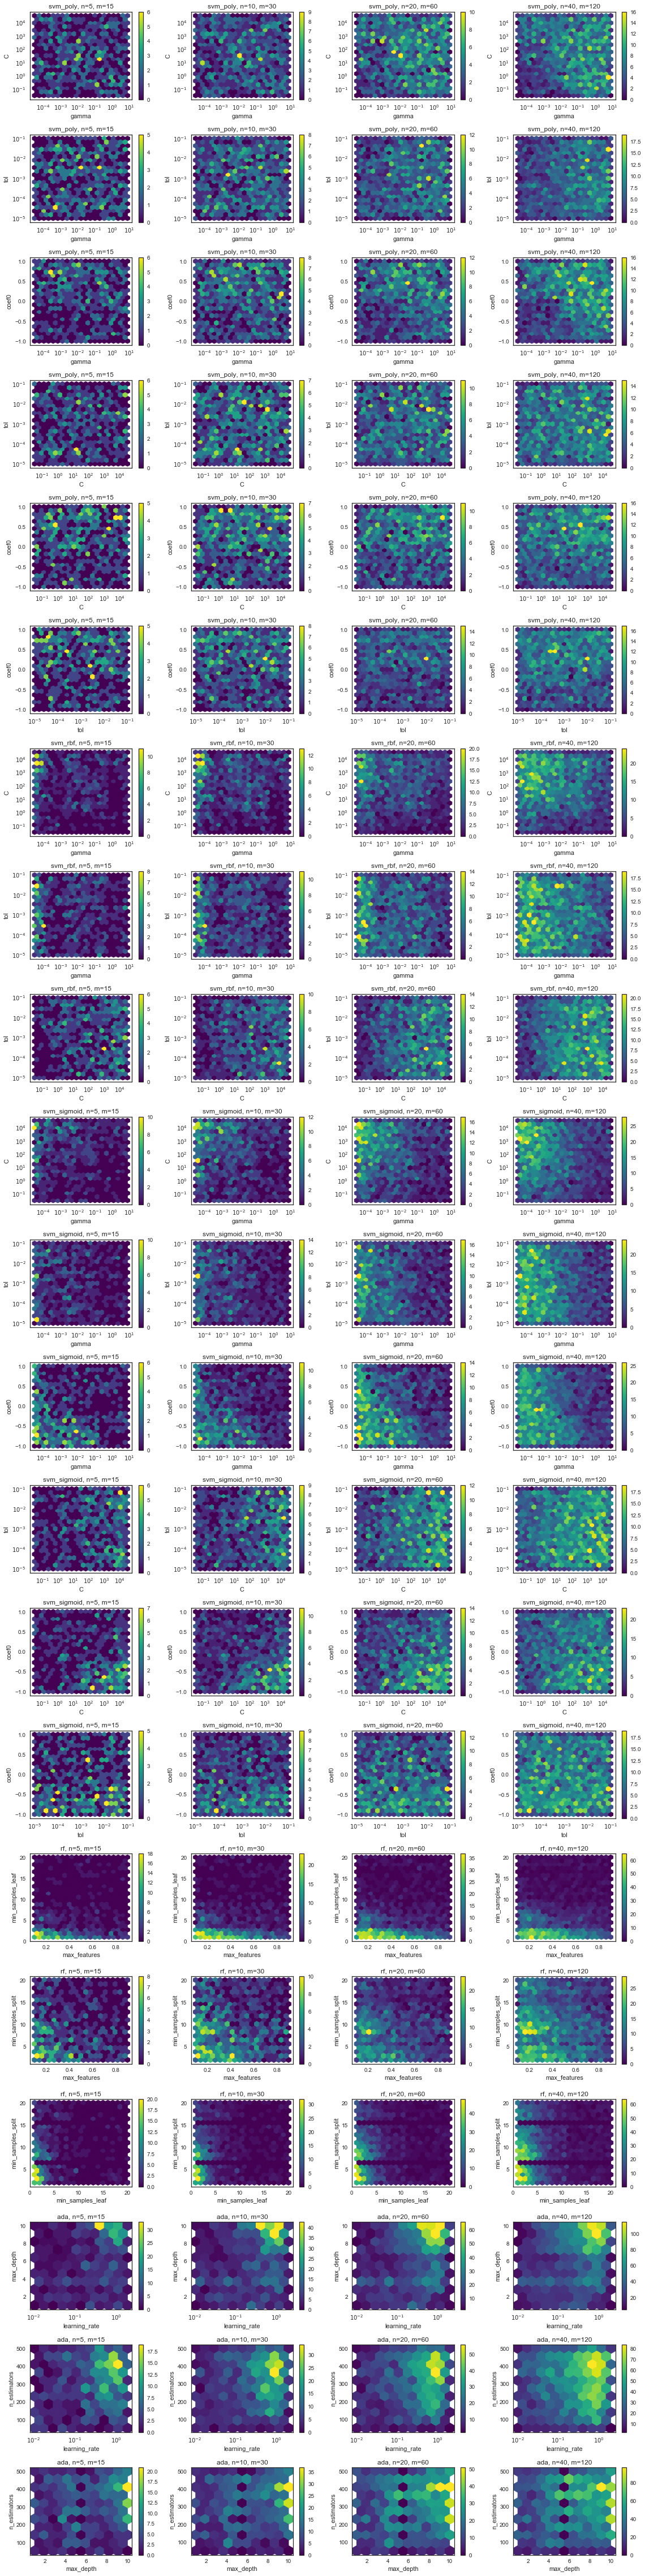

In [11]:
# load data
data = arff.loadarff('data/meta_svm.arff')
svm = pd.DataFrame(data[0])
data = arff.loadarff('data/meta_random_forest.arff')
rf = pd.DataFrame(data[0])
data = arff.loadarff('data/meta_adaboost.arff')
ada = pd.DataFrame(data[0])
# load alg names and dataframes
g = svm.groupby('kernel')
algs = ['svm_' + s.decode('UTF-8') for s in list(g.groups.keys())] + ['rf', 'ada']
dfs_all = [g.get_group(x) for x in g.groups] + [rf, ada]
# hyperparameters to be evaluated
alg_params = {'svm_poly': ['gamma','C','tol','coef0'],
              'svm_rbf': ['gamma','C','tol'],
              'svm_sigmoid': ['gamma','C','tol','coef0'],
              'rf': ['max_features','min_samples_leaf','min_samples_split'],
              'ada': ['learning_rate','max_depth','n_estimators']}

# parameters defined on a log scale
logs = ['gamma', 'C', 'tol', 'learning_rate']
integer = ['min_samples_leaf', 'min_samples_split', 'max_depth', 'n_estimators']

# PARAMETERS
ns = [5, 10, 20, 40] # top n observations 
ms = [15, 30, 60, 120] # minimum number of observations in dataset
gridsize = 20 #nr of points that are normally evaluated for the hexbin plot

sns.set_style("white")


dfs_top = []
for n, m in zip(ns, ms):
    dfs_top.append(retrieve_topn(dfs_all, algs, n, m))

# plot hexbins per alg_param combination
cols = len(dfs_top)
rows = 1
for alg, df in zip(algs, dfs):
    for i in range(0, len(alg_params[alg])):
        for j in range(i + 1, len(alg_params[alg])):
            rows += 1
fig = plt.figure(figsize = (4*cols,3*rows))
index = 0

for alg, alg_nr in zip(algs, range(0, len(algs))):
    for i in range(0, len(alg_params[alg])):
        for j in range(i + 1, len(alg_params[alg])):
            for df_nr in range(0, len(dfs_top)):
                df = dfs_top[df_nr][alg_nr]
                n = ns[df_nr]
                m = ms[df_nr]

                index += 1
                param1 = alg_params[alg][i]
                param2 = alg_params[alg][j]
                log1 = param1 in logs
                intg1 = param1 in integer
                log2 = param2 in logs
                intg2 = param2 in integer
                x = df[param1]
                y = df[param2]

                bins = None
                if log1:
                    xscale = 'log'
                else:
                    xscale = 'linear'
                if log2:
                    yscale = 'log'
                else:
                    yscale = 'linear'

                if intg1 and param1 != 'n_estimators':
                    xmax = max(df[param1])
                    xmin = min(df[param1])
                    gridsize = int(xmax - xmin + 1)
                if intg2 and param2 != 'n_estimators':
                    ymax = max(df[param2])
                    ymin = min(df[param2])
                    gridsize = int(ymax - ymin + 1)
                    
                ax = fig.add_subplot(rows, cols, index)
                cmap = ax.hexbin(x=x, y=y, cmap = 'viridis', xscale = xscale, yscale = yscale, gridsize = gridsize)
                ax.set_title('%s, n=%s, m=%s' %(alg, str(n), str(m)))
                ax.set_xlabel(param1)
                ax.set_ylabel(param2)
                plt.tight_layout()
                plt.colorbar(cmap, ax=ax)
plt.show()